In [1]:
import matplotlib.pyplot as plt
import sklearn.model_selection
from sklearn.metrics import accuracy_score
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv("../data/train.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test = pd.read_csv("../data/test.csv")
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
women = data.loc[data.Sex == "female"]["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

% of women who survived: 0.7420382165605095


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


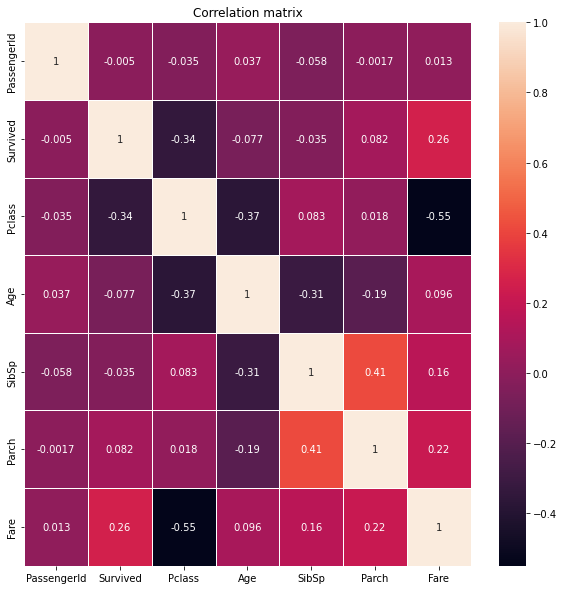

In [7]:
corr = data.corr()
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(corr, annot=True, linewidth=0.5)
ax.set_title("Correlation matrix")
plt.show()

In [8]:
features = ["Pclass", "Sex", "SibSp", "Parch"]
X_train = np.array(pd.get_dummies(data[features]))

y_train = np.array(data["Survived"])

print(f"Shape of the training set: {X_train.shape}")

Shape of the training set: (891, 5)


In [9]:
def train_classifier(X_train, y_train, model_name, classifier, params, score, verbose=False, num_folds=10):
    
    kf = sklearn.model_selection.StratifiedKFold(num_folds)
    
    train_scores = []
    best_score = 0
    
    for cfg in sklearn.model_selection.ParameterGrid(params):
        train_scores_run = []
        counts = []
        for train_indices, valid_indices in kf.split(X_train, y_train):
            counts.append(len(train_indices))
            X_train_kf = X_train[train_indices]
            y_train_kf = y_train[train_indices]
            X_valid_kf = X_train[valid_indices]
            y_valid_kf = y_train[valid_indices]
            
            model = classifier(**cfg)
            model.fit(X_train_kf, y_train_kf)
            y_hat = model.predict(X_valid_kf)
            train_score = score(y_valid_kf, y_hat)
            train_scores_run.append(train_score)
            
        if np.average(train_scores_run, weights=counts) > best_score:
            best_score = np.average(train_scores_run, weights=counts)
            best_cfg = cfg
            if(verbose):
                print("New best score obtained")
                print(f"Training with: {cfg}")
                print(f"Total score obtained with cross validation: {best_score}\n")
                
        train_scores.append(np.average(train_scores_run, weights=counts))
        
    output_df = pd.DataFrame(data=[[model_name, best_cfg, best_score]], 
                             columns=["model_name", "parameters", "training_score"])
    
    return output_df

In [10]:
results = pd.DataFrame()

In [11]:
from sklearn.neighbors import KNeighborsClassifier

params = {
    "n_neighbors": [1, 3, 5, 7, 9, 11, 13, 15]
}
clf = KNeighborsClassifier
clf_df = train_classifier(X_train, y_train, "k-NN", clf, params, accuracy_score)
results = results.append(clf_df)

In [12]:
from sklearn.svm import LinearSVC

params = {
    "C": [1e-3, 1e-2, 1e-1, 1],
    "max_iter": [30000],
}
clf = LinearSVC
clf_df = train_classifier(X_train, y_train, "LinearSVC", clf, params, accuracy_score)
results = results.append(clf_df)

In [13]:
from sklearn.svm import SVC
params = {
    "kernel": ["rbf"],
    "C": [1e-4, 1e-3, 1e-2, 1e-1, 1, 10],
    "gamma": [1e-3, 1e-2, 1e-1, 1, 10]
}
clf = SVC
clf_df = train_classifier(X_train, y_train, "SVC", clf, params, accuracy_score)
results = results.append(clf_df)

In [14]:
from sklearn.linear_model import LogisticRegression

params = {
    "C": [1e-3, 1e-2, 1e-1, 1, 10]
}
clf = LogisticRegression
clf_df = train_classifier(X_train, y_train, "LogisticRegression", clf, params, accuracy_score)
results = results.append(clf_df)

In [15]:
from sklearn.ensemble import RandomForestClassifier

params = {
    "max_depth": [3, 5, 7, 10, None],
    "n_estimators": [3, 5, 10, 25, 50],
    "max_features": [1, 2, "auto"]
}
clf = RandomForestClassifier
clf_df = train_classifier(X_train, y_train, "RandomForests", clf, params, accuracy_score)
results = results.append(clf_df)

In [16]:
results = results.set_index("model_name")
results

,parameters,training_score
model_name,,
k-NN,{'n_neighbors': 7},0.793524
LinearSVC,"{'C': 1, 'max_iter': 30000}",0.793482
SVC,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}",0.806967
LogisticRegression,{'C': 1},0.799087
RandomForests,"{'max_depth': 3, 'max_features': 1, 'n_estimat...",0.805830


In [17]:
# Fit the best model with the full training dataset again
best_clf = SVC
best_params = results.loc["SVC"]["parameters"]
submission_model = best_clf(**best_params)
submission_model.fit(X_train, y_train)

X_test = np.array(pd.get_dummies(test[features]))
preds = submission_model.predict(X_test)

output = pd.DataFrame({
    "PassengerId": test.PassengerId,
    "Survived": preds,
})
output.to_csv("submission_v2.csv", index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
